In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import pickle

In [3]:
!pip uninstall -y tensorflow

In [4]:
!pip install  tensorflow-gpu==2.0.0-beta1

In [0]:
import tensorflow as tf

In [6]:
tf.__version__

'2.0.0-beta1'

In [0]:
!pip install -q imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [9]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/content/drive', force_remount=True)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [10]:
import os
os.chdir("./drive/My Drive/MLDATA/BACKGROUND")
!ls

GEN_256.pkl  Real_256.pkl  Test_256.pkl  TestReal_256.pkl  training_checkpoints
GEN_32.pkl   Real_32.pkl   Test_32.pkl	 TestReal_32.pkl
GEN.pkl      Real.pkl	   Test.pkl	 TestReal.pkl


In [0]:
with open('Real_256.pkl','rb') as f:
  train_images=pickle.load(f)
  
with open('GEN_256.pkl','rb') as f:
  gen_data=pickle.load(f)  
  
with open('Test_256.pkl','rb') as f:
  test_data=pickle.load(f) 
  
with open('TestReal_256.pkl','rb') as f:
  test_real_data=pickle.load(f) 
    
  


In [0]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 2
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((gen_data,train_images)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_data,test_real_data)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [17]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(train_images[0], 0))
print (down_result.shape)
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)
(1, 256, 256, 3)


In [0]:
def Generator():
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
generator = Generator()
generator.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, None, None, 6 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, None, None, 1 131584      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, None, None, 2 525312      sequential_3[0][0]               
______________________________________________________________________________________________

W0808 09:20:17.813739 140281295955840 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


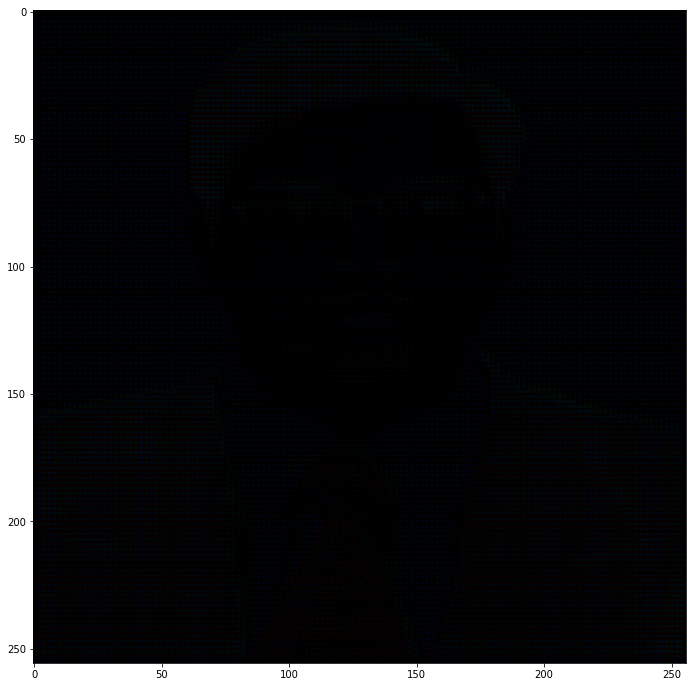

In [20]:
gen_output = generator(train_images[0][tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

W0808 09:20:18.221527 140281295955840 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


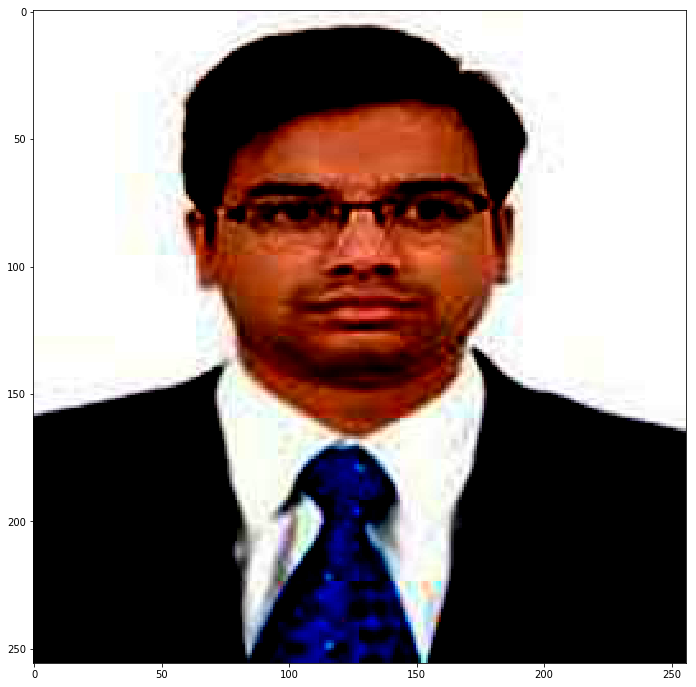

In [21]:
plt.imshow(train_images[0])

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

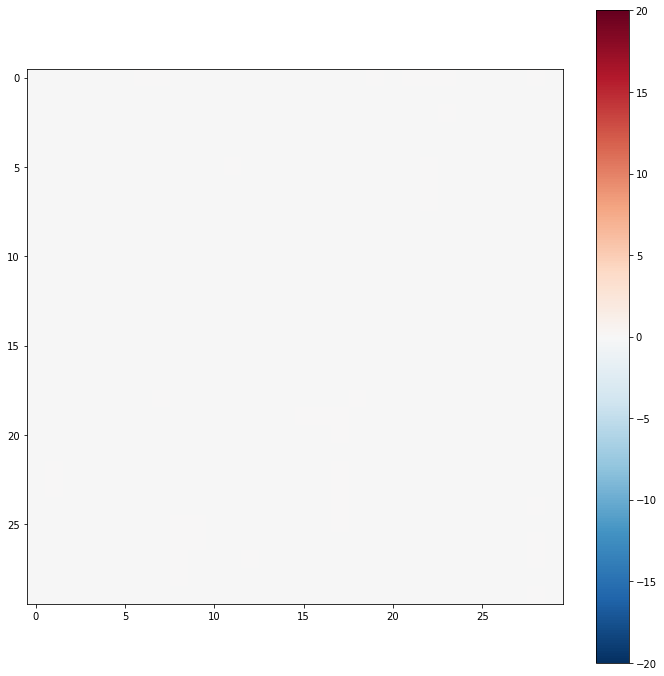

In [23]:
discriminator = Discriminator()
disc_out = discriminator([train_images[0][tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [0]:
LAMBDA = 100

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 150

In [0]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [0]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for input_image, target in dataset:
      train_step(input_image, target)

    clear_output(wait=True)
    for inp, tar in test_dataset.take(1):
      generate_images(generator, inp, tar)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

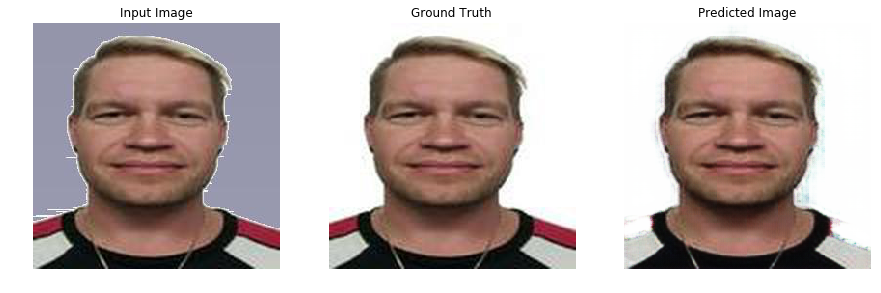

Time taken for epoch 39 is 16.647932291030884 sec



In [0]:
train(train_dataset, EPOCHS)

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset.take(4):
  print(inp.shape)
  #generate_images(generator, inp, tar)